<a href="https://colab.research.google.com/github/r4phael/ml-course/blob/master/notebooks/2_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Semana 2 - Modelos de Classificação**

### Importando libs  e funções

Importando libs

In [0]:
import pandas as pd
import random
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix

# Importando libs de visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Importando funções

In [0]:
# Função que calcula os reais positivos
def rp(tp, fn):
    return tp + fn

# Função que calcula os reais negativos     
def rn(fp, tn):
    return fp + tn

# Função que calcula as predicoes positivas  
def pp(tp, fp):
    return tp + fp

# Função que calcula as predicoes negativas   
def pn(fn, tn):
    return fn + tn

# Função que calcula acurácia do modelo
def accuracy (tp, fp, fn, tn):
     accuracy = ((tp + tn) / (tp + tn + fp + fn))
     return (accuracy)
    
# Função que calcula a precisão 
def precision (tp, fp):
    precision =  (tp / (tp + fp)) #predições positivas
    return precision

# Função que calcula o recall
def recall(tp, fn):
    recall =  (tp / (tp + fn)) # reais positivos
    return recall

## Função que calcula o f-measure (media harmonica entre precision e recall)
def f_measure(tp, fp, fn):
    f_measure = (2 * precision(tp, fp) * recall(tp, fn)) / (recall(tp, fn) + precision(tp, fp))
    return f_measure
  
# Função que calcula o Informedness 
def informedness(tp, fp, fn, tn):
    inform = ((tp/rp(tp, fn)) - (fp/rn(fp, tn)))
    return inform

# Função que calcula o Markedness
def markdness(tp, fp, fn, tn):    
    mark = ((tp/pp(tp,fp)) - (fn/pn(fn,tn)))
    return mark

# Função de escalonamento
def feature_scaling(data):
    sc = StandardScaler()
    return sc.fit_transform(data)

# Função que gera o gráfico dos resultados de classificação
def plot_results_class(X, y, classifier, title):
    X_set, y_set = X, y
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green'))(i), label = j)
    plt.title(title)
    plt.xlabel('Idade')
    plt.ylabel('Tarifa')
    plt.legend()
    plt.show()

### Etapa de exploração e tratamento dos dados

Importando os dados dos passageiros do titanic e selecionando uma amostragem dos dados para uma melhor visualização. O objetivo dessa tarefa de classificação é prever os passageiros sobreviventes com base nas suas informações pessoais.

Fonte: [Kaggle](https://www.kaggle.com/c/titanic/data)

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/r4phael/ml-course/master/data/titanic.csv')
df = df.sample(n=100, random_state=0)

Descrevendo o dataset

In [0]:
# Exporando o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 495 to 681
Data columns (total 12 columns):
PassengerId    100 non-null int64
Survived       100 non-null int64
Pclass         100 non-null int64
Name           100 non-null object
Sex            100 non-null object
Age            79 non-null float64
SibSp          100 non-null int64
Parch          100 non-null int64
Ticket         100 non-null object
Fare           100 non-null float64
Cabin          29 non-null object
Embarked       100 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 10.2+ KB


In [0]:
# Visualizando o sumário das colunas numéricas do dataset
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,100.00000,100.00000,100.000000,79.000000,100.000000,100.000000,100.000000
mean,475.30000,0.43000,2.100000,27.948354,0.570000,0.430000,39.693957
std,256.15985,0.49757,0.881917,14.728176,1.046929,0.768772,51.751419
min,9.00000,0.00000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,270.00000,0.00000,1.000000,19.000000,0.000000,0.000000,8.626050
50%,501.50000,0.00000,2.000000,26.000000,0.000000,0.000000,25.039600
75%,688.75000,1.00000,3.000000,35.000000,1.000000,1.000000,37.462500
max,891.00000,1.00000,3.000000,63.000000,4.000000,4.000000,263.000000


Visualizando o dataset

In [0]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
495,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


Preenchendo os valores númericos nulos (NA) com a mediana.

In [0]:
df = df.fillna(df.median())

df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
495,496,0,3,"Yousseff, Mr. Gerious",male,26.0,0,0,2627,14.4583,NaN,C
648,649,0,3,"Willey, Mr. Edward",male,26.0,0,0,S.O./P.P. 751,7.5500,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,26.0,1,0,PC 17569,146.5208,B78,C
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


Definindo as variáveis independentes e visualizando as 5 primeiras:

In [0]:
X = df.iloc[:, [5, 9]].values
X[:5]


array([[ 26.    ,  14.4583],
       [ 26.    ,   7.55  ],
       [  7.    ,  29.125 ],
       [ 26.    , 146.5208],
       [ 29.    ,  15.2458]])

Definindo as variáveis dependentes e visualizando as 5 primeiras:

In [0]:
y = df.iloc[:, 1].values
y[:5]


array([0, 0, 0, 1, 1])

 Criando os subconjuntos de treinamento e testes:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

print("Tamanho do Dataset. {}".format(df.shape[0]))
print("Tamanho do Conjunto de Treinamento. {}".format(len(X_train)))
print("Tamanho do Conjunto de Testes. {}".format(len(X_test)))

Tamanho do Dataset. 100
Tamanho do Conjunto de Treinamento. 80
Tamanho do Conjunto de Testes. 20


Normalizando as features e exibindo as 5 primeiras:

In [0]:
X_train = feature_scaling(X_train)
X_test = feature_scaling(X_test)

X_train[:5]

array([[-0.2233842 ,  0.62589282],
       [ 0.50330481, -0.63776468],
       [ 0.35796701, -0.68999987],
       [-0.0780464 , -0.55753246],
       [-0.58672871, -0.2466326 ]])

Treinando o modelo de Árvore de Decisão com o Conjunto de Treinamento

### Modelo - Arvore de Decisão

Importando e treinando o modelo com o conjunto de treinamento:

In [0]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

Prevendo os resultados do modelo criado com o conjunto de testes

In [0]:
y_pred = classifier.predict(X_test)

y_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1])

Criando e exibindo os valores da matriz de confusão com o conjunto de testes 

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

confusion_matrix(y_test, y_pred)

array([[11,  4],
       [ 1,  4]])

Visualizando a matriz de confusão

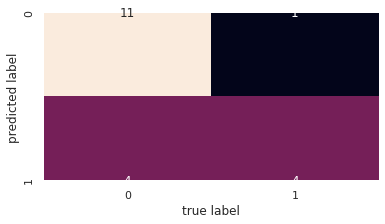

In [0]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Visualizando a métrica de **acurácia** utilizando as funções criadas e a bibilioteca sklearn:

In [0]:
accuracy(tp, fp, fn, tn)
classifier.score(X_test, y_test)

0.75

Exibindo a medida **f-measure**:

In [0]:
f_measure(tp, fp, fn)
f1_score(y_test, y_pred)  

0.6153846153846154

Exibindo os resultados do conjunto de treinamento:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


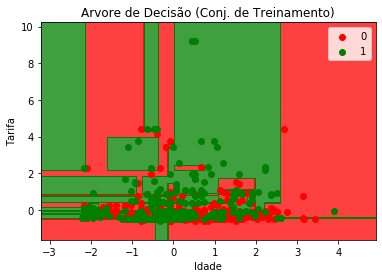

In [0]:
plot_results_class(X_train, y_train, classifier, 'Arvore de Decisão (Conj. de Treinamento)')

Exibindo os resultados do conjunto de testes:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


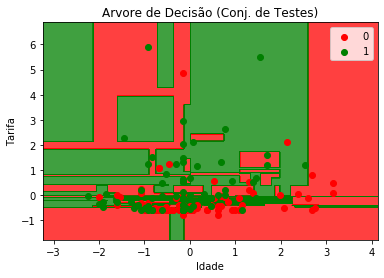

In [0]:
plot_results_class(X_test, y_test, classifier, 'Arvore de Decisão (Conj. de Testes)')

### Modelo - KNN

Importando e treinando o modelo com o conjunto de treinamento:

In [0]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Prevendo os resultados do modelo criado com o conjunto de testes

In [0]:
y_pred = classifier.predict(X_test)

y_pred

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

Criando e exibindo os valores da matriz de confusão com o conjunto de testes 

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

confusion_matrix(y_test, y_pred)

array([[ 4, 11],
       [ 3,  2]])

Visualizando a matriz de confusão

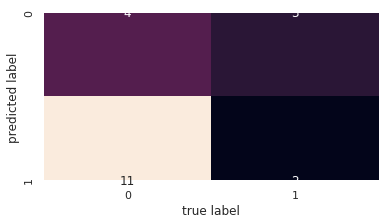

In [0]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Visualizando a métrica de **acurácia** utilizando as funções criadas e a bibilioteca sklearn:

In [0]:
accuracy(tp, fp, fn, tn)
classifier.score(X_test, y_test)

0.3

Exibindo a medida **f-measure**:

In [0]:
f_measure(tp, fp, fn)
f1_score(y_test, y_pred)  

0.2222222222222222

Exibindo os resultados do conjunto de treinamento:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


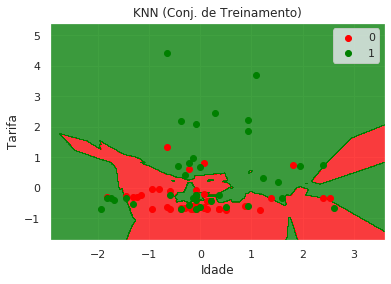

In [0]:
plot_results_class(X_train, y_train, classifier, 'KNN (Conj. de Treinamento)')

Exibindo os resultados do conjunto de testes:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


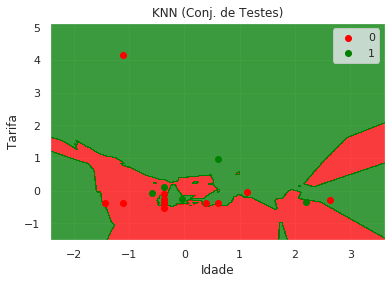

In [0]:
plot_results_class(X_test, y_test, classifier, 'KNN (Conj. de Testes)')

### Modelo - Regressão Logística

Importando e treinando o modelo com o conjunto de treinamento:

In [0]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Prevendo os resultados do modelo criado com o conjunto de testes

In [0]:
y_pred = classifier.predict(X_test)

y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

Criando e exibindo os valores da matriz de confusão com o conjunto de testes 

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

confusion_matrix(y_test, y_pred)

array([[14,  1],
       [ 3,  2]])

Visualizando a matriz de confusão

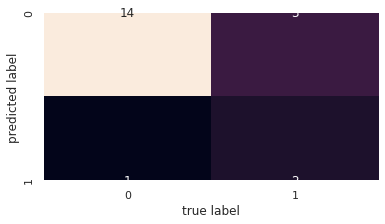

In [0]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Visualizando a métrica de **acurácia** utilizando as funções criadas e a bibilioteca sklearn:

In [0]:
accuracy(tp, fp, fn, tn)
classifier.score(X_test, y_test)

0.8

Exibindo a medida **f-measure**:

In [0]:
f_measure(tp, fp, fn)
f1_score(y_test, y_pred)  

0.5

Exibindo os resultados do conjunto de treinamento:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


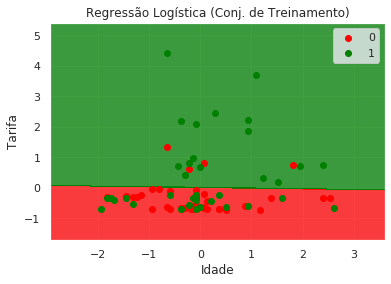

In [0]:
plot_results_class(X_train, y_train, classifier, 'Regressão Logística (Conj. de Treinamento)')

Exibindo os resultados do conjunto de testes:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


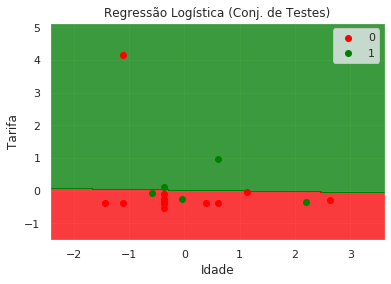

In [0]:
plot_results_class(X_test, y_test, classifier, 'Regressão Logística (Conj. de Testes)')

### Modelo - Naive Bayes

Importando e treinando o modelo com o conjunto de treinamento:

In [0]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Prevendo os resultados do modelo criado com o conjunto de testes

In [0]:
y_pred = classifier.predict(X_test)

y_pred

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

Criando e exibindo os valores da matriz de confusão com o conjunto de testes 

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

confusion_matrix(y_test, y_pred)

array([[13,  2],
       [ 4,  1]])

Visualizando a matriz de confusão

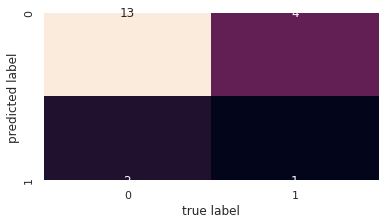

In [0]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Visualizando a métrica de **acurácia** utilizando as funções criadas e a bibilioteca sklearn:

In [0]:
accuracy(tp, fp, fn, tn)
classifier.score(X_test, y_test)

0.7

Exibindo a medida **f-measure**:

In [0]:
f_measure(tp, fp, fn)
f1_score(y_test, y_pred)  

0.25

Exibindo os resultados do conjunto de treinamento:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


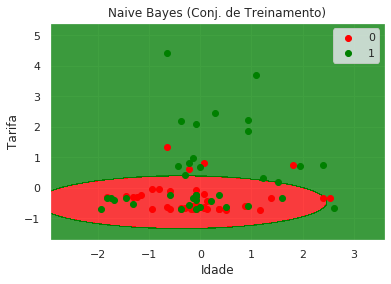

In [0]:
plot_results_class(X_train, y_train, classifier, 'Naive Bayes (Conj. de Treinamento)')

Exibindo os resultados do conjunto de testes:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


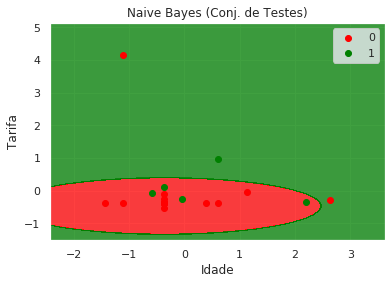

In [0]:
plot_results_class(X_test, y_test, classifier, 'Naive Bayes (Conj. de Testes)')

### Modelo - Random Forest

Importando e treinando o modelo com o conjunto de treinamento:

In [0]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Prevendo os resultados do modelo criado com o conjunto de testes

In [0]:
y_pred = classifier.predict(X_test)

y_pred

array([1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

Criando e exibindo os valores da matriz de confusão com o conjunto de testes 

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

confusion_matrix(y_test, y_pred)

array([[ 3, 12],
       [ 2,  3]])

Visualizando a matriz de confusão

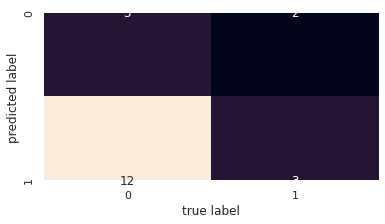

In [0]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Visualizando a métrica de **acurácia** utilizando as funções criadas e a bibilioteca sklearn:

In [0]:
accuracy(tp, fp, fn, tn)
classifier.score(X_test, y_test)

0.3

Exibindo a medida **f-measure**:

In [0]:
f_measure(tp, fp, fn)
f1_score(y_test, y_pred)  

0.3

Exibindo os resultados do conjunto de treinamento:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


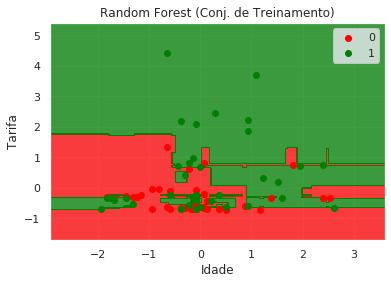

In [0]:
plot_results_class(X_train, y_train, classifier, 'Random Forest (Conj. de Treinamento)')

Exibindo os resultados do conjunto de testes:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


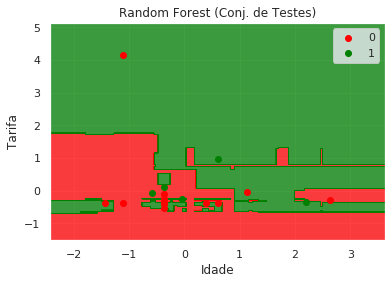

In [0]:
plot_results_class(X_test, y_test, classifier, 'Random Forest (Conj. de Testes)')

### Modelo - SVC

Importando e treinando o modelo com o conjunto de treinamento:

In [0]:
from sklearn.svm import SVC

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

Prevendo os resultados do modelo criado com o conjunto de testes

In [0]:
y_pred = classifier.predict(X_test)

y_pred

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1])

Criando e exibindo os valores da matriz de confusão com o conjunto de testes 

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

confusion_matrix(y_test, y_pred)

array([[12,  3],
       [ 3,  2]])

Visualizando a matriz de confusão

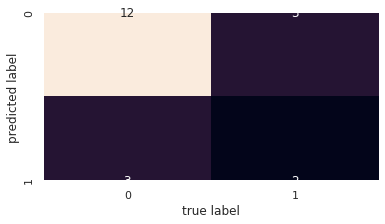

In [0]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Visualizando a métrica de **acurácia** utilizando as funções criadas e a bibilioteca sklearn:

In [0]:
accuracy(tp, fp, fn, tn)
classifier.score(X_test, y_test)

0.7

Exibindo a medida **f-measure**:

In [0]:
f_measure(tp, fp, fn)
f1_score(y_test, y_pred)  

0.4000000000000001

Exibindo os resultados do conjunto de treinamento:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


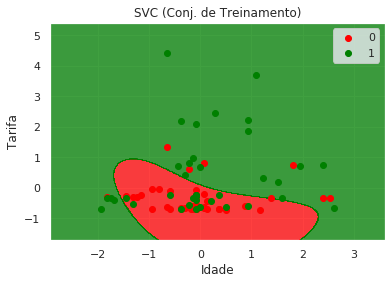

In [0]:
plot_results_class(X_train, y_train, classifier, 'SVC (Conj. de Treinamento)')

Exibindo os resultados do conjunto de testes:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


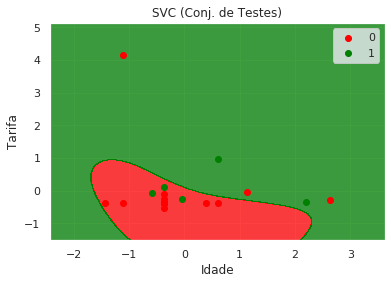

In [0]:
plot_results_class(X_test, y_test, classifier, 'SVC (Conj. de Testes)')

### Estudo de Caso: Pipeline de Aprendizagem de Máquina

**Descrição do estudo de caso.**

Importando as libs:

In [0]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

Visualizando e descrevendo  o dataset

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/r4phael/ml-course/master/data/titanic.csv')
# Descrevendo o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
# Visualizando o dataset
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Deletando as features que não tem importância no modelo: Nome, Código do Ticket e Código da Cabine:*italicized text*

In [0]:
df = df.drop(['Name','Ticket','Cabin', 'PassengerId'], axis = 1)

Preenchendo os valores númericos nulos (NA) com a mediana.

In [0]:
df = df.fillna(df.median())

 Criando variaǘeis Dummy nas variáveis categóricas

In [0]:
df = pd.get_dummies(df ,prefix=['Sex', 'Embarked'], drop_first=True)

Visualizando o dataset após o tratamento dos dados:

In [0]:
df.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1
5,0,3,28.0,0,0,8.4583,1,1,0
6,0,1,54.0,0,0,51.8625,1,0,1
7,0,3,2.0,3,1,21.0750,1,0,1
8,1,3,27.0,0,2,11.1333,0,0,1
9,1,2,14.0,1,0,30.0708,0,0,0


Definindo as variáveis dependentes/independentes.

In [0]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

Criando os subconjuntos de treinamento e testes

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


Normalizando as features 

In [0]:
X_train = feature_scaling(X_train)
X_test = feature_scaling(X_test)

Criando o dicionário contendo todos os classificadores

In [0]:
estimators = {'Decision Tree': DecisionTreeClassifier(criterion = 'entropy', random_state = 0),
              'KNN': KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
              'Logistic Regression': LogisticRegression(random_state = 0),
              'Naive Bayes': GaussianNB(),
              'Random Forest': RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0),
              'SVC': SVC(kernel = 'rbf', random_state = 0)}

Criando dataframe que irá guardar os resultados finais dos classificadores

In [0]:
df_results = pd.DataFrame(columns=['clf', 'acc', 'prec', 'rec', 'f1', 'inform', 'mark'], index=None)


Itereando os classificadores e gerando os resultados para cada classificador:

In [0]:
for name, estim in estimators.items():
    # print("Treinando Estimador {0}: ".format(name))
    
    # Treinando os classificadores com Conjunto de Treinamento
    estim.fit(X_train, y_train)
    
    # Prevendo os resultados do modelo criado com o conjunto de testes
    y_pred = estim.predict(X_test)
    
    # Criando a matriz de confusão com o conjunto de testes 
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # print("accuracy {0}: ".format(accuracy(tp, fp, fn, tn)))
    
    # Armazenando as métricas de cada classificador em um dataframe
    df_results.loc[len(df_results), :] = [name, accuracy(tp, fp, fn, tn), precision (tp, fp), recall(tp, fn), 
                   f_measure(tp, fp, fn), informedness(tp, fp, fn, tn), markdness(tp, fp, fn, tn)]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Exibindo os resultados finais

In [0]:
df_results

,clf,acc,prec,rec,f1,inform,mark
0,Decision Tree,0.782123,0.734375,0.681159,0.706767,0.526614,0.543071
1,KNN,0.810056,0.79661,0.681159,0.734375,0.572069,0.613277
2,Logistic Regression,0.815642,0.78125,0.724638,0.75188,0.597365,0.616033
3,Naive Bayes,0.793296,0.728571,0.73913,0.733813,0.566403,0.563434
4,Random Forest,0.865922,0.894737,0.73913,0.809524,0.684585,0.747196
5,SVC,0.810056,0.807018,0.666667,0.730159,0.566667,0.618493
